In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0
  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0
  gnutls             conda-forge/linux-64::gnutls-3.6.13-h85f3911_1
  lame               conda-forge/linux-64::lame-3.100-h7f98852_1001
  libiconv           conda-forge/linux-64::libiconv-1.17-h166bdaf_0
  nettle             conda-forge/linux-64::nettle-3.6-he412f7d_0
  openh264           conda-forge/linux-64::openh264-2.1.1-h780b84a_0
  torchaudio         pytorch/linux-64::torchaudio-0.11.0-py37_cu113
  torchvision        pytorch/linux-64::torchvision-0.12.0-py37_cu113


Preparing transaction: done
Verifying transaction: done
Executing transaction: - WARNING conda.gateways

In [12]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomGrayscale(),
     transforms.RandomPerspective(),
     transforms.ToTensor(),
     transforms.Normalize((0.50, 0.50, 0.50), (0.50, 0.50, 0.50))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [13]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


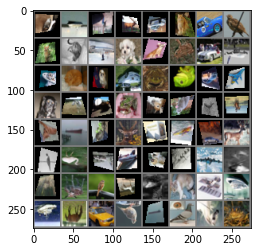

  cat  ship  bird  deer   car   cat   car  bird   cat   cat  ship   dog   dog  frog   car plane  ship   cat   dog   car  frog  frog   car plane   dog horse truck  frog  deer   cat  deer horse   dog  ship   cat  deer truck  ship   car  deer  bird  bird plane  ship   dog plane plane  deer  deer  deer  bird horse  bird   cat plane  ship  ship horse   car  bird  ship  bird horse  frog


In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048, 128)
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
        x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
        x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 100
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))
        
    valid_loss = 0.0
    valid_acc = 0.0
    # net.eval()     # Optional when not using Model Specific layer
    for inputs2, labels2 in testloader:
        inputs2,labels2=inputs2.to(device),labels2.to(device)
        # Forward Pass
        outputs2 = net(inputs2)
        # Find the Loss
        loss2 = criterion(outputs2,labels2)
        # Calculate Loss
        valid_loss += loss2.item()

        pred2=outputs2.argmax(dim=1,keepdim=True)
        valid_acc += ((pred2.eq(labels2.view_as(pred2)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Accuracy:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/100 	 Training Loss: 1.9753 	 Validation Loss: 1.8268 	 Training Accuracy: 0.2674 	 Validation Accuracy:0.3277
Epoch 2/100 	 Training Loss: 1.7448 	 Validation Loss: 1.7102 	 Training Accuracy: 0.3593 	 Validation Accuracy:0.3784
Epoch 3/100 	 Training Loss: 1.6289 	 Validation Loss: 1.5421 	 Training Accuracy: 0.4047 	 Validation Accuracy:0.441
Epoch 4/100 	 Training Loss: 1.5454 	 Validation Loss: 1.4933 	 Training Accuracy: 0.4349 	 Validation Accuracy:0.4598
Epoch 5/100 	 Training Loss: 1.4925 	 Validation Loss: 1.4244 	 Training Accuracy: 0.4586 	 Validation Accuracy:0.4835
Epoch 6/100 	 Training Loss: 1.4414 	 Validation Loss: 1.4675 	 Training Accuracy: 0.4785 	 Validation Accuracy:0.462
Epoch 7/100 	 Training Loss: 1.3942 	 Validation Loss: 1.445 	 Training Accuracy: 0.4934 	 Validation Accuracy:0.4823
Epoch 8/100 	 Training Loss: 1.3511 	 Validation Loss: 1.3592 	 Training Accuracy: 0.5139 	 Validation Accuracy:0.4982
Epoch 9/100 	 Training Loss: 1.3095 	 Validation Lo

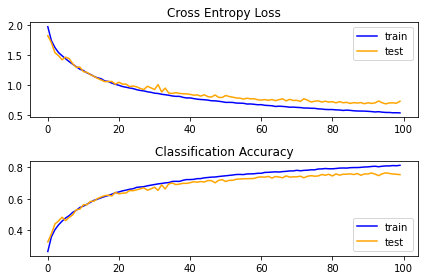

In [16]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

valid_acc = 0.0
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        
        valid_acc += ((predictions.eq(labels.view_as(predictions)).sum().item())/(10000))
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
print(f'Overall Accuracy{valid_acc*100}')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Overall Accuracy75.35000000000005
Accuracy for class plane is: 82.7 %
Accuracy for class car   is: 87.5 %
Accuracy for class bird  is: 62.4 %
Accuracy for class cat   is: 59.1 %
Accuracy for class deer  is: 63.9 %
Accuracy for class dog   is: 72.8 %
Accuracy for class frog  is: 81.6 %
Accuracy for class horse is: 73.5 %
Accuracy for class ship  is: 80.9 %
Accuracy for class truck is: 89.1 %
